In [1]:
import numpy as np
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
import time
from ipywidgets import interact
from os import path


In [12]:
def Gz(z_arr,a,b):
    ''' solves a cubic equation for G(z) numerically'''
    '''less efficient, but more reliable'''
    if isinstance(z_arr, list):
        z4=np.zeros(len(z_arr))
        for i_z in range(len(z_arr)):
            z= z_arr[i_z]
            z4[i_z]=np.imag(np.roots([z,b-1,a-z,1]))[1]
    else:
        z4=np.imag(np.roots([z_arr,b-1,a-z_arr,1]))[1]
    return np.abs(z4)


def plot_spectrum(V=10,Ra=0.6,R12=0.2):
    ''' plots the spectral density of partial transpose'''
    '''
    L1 subsystem A1 of N1 qubits
    L2 subsystem A2 of N2 qubits
    => LA=L1*L2
    Lb subsystem B of Nb qubits
    V= N1+N2+Nb total number of qubits (system size)
    R12= N1/(N1+N2), we assume L1<L2, i.e., 0<R12<0.5
    Ra= (N1+N2)/V
    '''
    r=2 # local Hilbert space dim
    a= r**((1-Ra)*V-(1-R12)*Ra*V) # Lb/L2
    b= a*r**(R12*Ra*V) # Lb L1/L2
    fx =  1/a
    fy =  pi/fx
#     fx =  1/(a/r**(R12*Ra*V))
#     fy =  pi/fx

    xplot=np.linspace(-1,1,1000)*1e3/fx+1j*0
    yplot=Gz(np.ndarray.tolist(xplot),a+1j*0,b+1j*0)
    plt.plot(np.real(xplot)*fx,fy*yplot)
    plt.title('Critical $R_{12}$: $1/2-\delta=$ %.2f' % (1-1/(2*Ra)) )
#     plt.ylim(0,0.04)
    plt.xlabel(r'$L_A\xi$')
    plt.ylabel('Spectral Density')
    plt.show()

interact(plot_spectrum, V=(10,100,10), Ra=(0,1,0.02), R12=(0,0.5,0.01));

interactive(children=(IntSlider(value=10, description='V', min=10, step=10), FloatSlider(value=0.6, descriptio…

In [16]:
from scipy.integrate import quad, nquad

def Gz(z,a,b):
    '''Direct solution to G(z), faster but has numerical instability for large V
    a=  Lb/L2
    b=  Lb*L1/L2
    '''
    a2= (b-1)/z +1j*0
    a1= (a-z)/z +1j*0
    a0= 1/z +1j*0
    Q= (3*a1-a2**2)/9 +1j*0
    R= (9*a2*a1-27*a0-2*a2**3)/54 +1j*0
    D= Q**3 + R**2 +1j*0
    S= (R+D**0.5 +1j*0)**(1/3)
    T= (R-D**0.5 +1j*0)**(1/3)
    z4= -a2/3 + (1-1j*sqrt(3))*Q/S/2-(1+1j*sqrt(3))/2*S
    return np.abs(np.imag(z4))

def integrand(z, a, b):
    return Gz(z,a,b)*np.abs(z)

def neg_calc(a,b):
    '''Calculates logneg by \int P(z)|z| dz
    where P(z) is spectral density'''
    options={'limit':500}
    integral= nquad(integrand, [[-np.inf, np.inf]], args=(a, b),opts=[options,options])[0]
    return integral

r=2 # local Hilbert space dim
def logneg_plotter(V=20,Ra=0.6):
    R12_list=np.linspace(0.01,0.49,100)
    logneg=np.zeros(len(R12_list))
    for i_1 in range(len(R12_list)):
        R12=R12_list[i_1]
        Lb= r**((1-Ra)*V)
        L1= r**(R12*Ra*V)
        L2= r**((1-R12)*Ra*V)

        a = Lb/L2 +1j*0
        b = Lb/L2*L1 +1j*0
        logneg[i_1]=np.log2(neg_calc(a,b)*(L2*L1)/pi/(L1*Lb))
        
    plt.plot(R12_list,logneg/V,'-',label='V=%.2f' % (V))
    plt.plot(R12_list,R12_list*Ra,'--')
    plt.plot([(1-1/(2*Ra))]*2,[R12_list[0]*Ra,R12_list[-1]*Ra],'k--')
    plt.xlabel('$N_{A_1}/N_A$')
    plt.ylabel('LogNeg')
    plt.show()

interact(logneg_plotter, V=(4,32,4),Ra=(0,1,0.05));

interactive(children=(IntSlider(value=20, description='V', max=32, min=4, step=4), FloatSlider(value=0.6, desc…

In [ ]:
# shows finite size effects (previous cell contains the functions, next cell contains plots)
r=2 # local Hilbert space dim
Ra=0.6 # (N1+N2)/V
Vlist=np.arange(10,61,10)
R12_list=np.linspace(0.01,0.49,100)
logneg=np.zeros((len(R12_list),len(Vlist)))
for i_V in range(len(Vlist)):
    V=Vlist[i_V]
    t_timer=time.time()
    
    for i_1 in range(len(R12_list)):
        R12=R12_list[i_1]
        Lb= r**((1-Ra)*V)
        L1= r**(R12*Ra*V)
        L2= r**((1-R12)*Ra*V)

        a = Lb/L2 +1j*0
        b = Lb/L2*L1 +1j*0
        logneg[i_1,i_V]=np.log2(neg_calc(a,b)*(L2*L1)/pi/(L1*Lb))    
        
    elapsed = time.time() - t_timer
    print("logneg was calculated for %d qubits" % (V) + ", elapsed time = %.2f " % (elapsed)+ "sec")

logneg was calculated for 10 qubits, elapsed time = 4.62 sec


/gscratch/home/hshapourian/miniconda3/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


logneg was calculated for 20 qubits, elapsed time = 4.68 sec


<ipython-input-16-ac1706741f7e>:16: RuntimeWarning: divide by zero encountered in cdouble_scalars
  z4= -a2/3 + (1-1j*sqrt(3))*Q/S/2-(1+1j*sqrt(3))/2*S
<ipython-input-16-ac1706741f7e>:16: RuntimeWarning: invalid value encountered in cdouble_scalars
  z4= -a2/3 + (1-1j*sqrt(3))*Q/S/2-(1+1j*sqrt(3))/2*S
/gscratch/home/hshapourian/miniconda3/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/gscratch/home/hshapourian/miniconda3/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtaine

logneg was calculated for 30 qubits, elapsed time = 6.17 sec


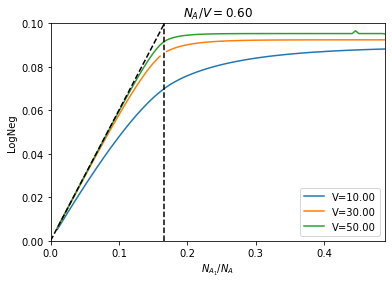

In [33]:
plt.figure()
for i_V in range(len(Vlist)):
    V=Vlist[i_V]
    plt.plot(R12_list,logneg[:,i_V]/V,'-',label='V=%.2f' % (V),color='C%d' % (i_V))
    
if Ra>0.5:
    ymax=0.1
    plt.plot([0,ymax/Ra],[0,ymax],'k--')
    plt.plot([(1-1/(2*Ra))]*2,[0,ymax],'k--')
    plt.ylim(0,ymax)
plt.xlim(0,R12_list[-1])
plt.title('$N_A/V=$%.2f' % (Ra) )
plt.xlabel('$N_{A_1}/N_A$')
plt.ylabel('LogNeg')
plt.legend(loc='lower right')
plt.show()

In [462]:
from scipy.integrate import quad, nquad

def integrand(z, a, b):
#     return Gz(z,a,b)/pi* np.abs(z)
    return Gz(z,a,b)*(L2*L1)/pi *np.abs(z)

def neg_calc(a,b):
#     integral= np.log2(quad(integrand, -np.inf, np.inf, args=(a, b))[0])
    options={'limit':500}
    integral= nquad(integrand, [[-np.inf, np.inf]], args=(a, b),opts=[options,options])[0]
    return integral

r=2

R12=0.3
Vlist=np.arange(20,41,20)
Ra_list=np.linspace(0.4,0.99,100)
logneg=np.zeros((len(Ra_list),len(Vlist)))
for i_V in range(len(Vlist)):
    V=Vlist[i_V]
    print(V)
    t_timer=time.time()
    
    for i_a in range(len(Ra_list)):
        Ra=Ra_list[i_a]
        Lb= r**((1-Ra)*V)
        L1= r**(R12*Ra*V)
        L2= r**((1-R12)*Ra*V)

        a = Lb/L2 +1j*0
        b = Lb/L2*L1 +1j*0
        logneg[i_a,i_V]=np.log2(neg_calc(a,b)/(L1*Lb))    
        
    elapsed = time.time() - t_timer
    print("Finished, elapsed time = %.2f " % (elapsed)+ "sec")

20


<ipython-input-462-fe7d2c07569d>:32: RuntimeWarning: divide by zero encountered in log2
  logneg[i_a,i_V]=np.log2(neg_calc(a,b)/(L1*Lb))


Finished, elapsed time = 26.30 sec
40
Finished, elapsed time = 23.29 sec


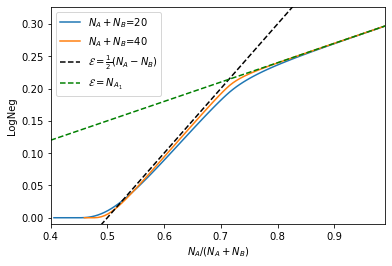

In [467]:
plt.figure()
for i_V in range(len(Vlist)):
# for i_V in [0]:
    V=Vlist[i_V]
    plt.plot(Ra_list,logneg[:,i_V]/V,'-',label='$N_A+N_B$=%.0f' % (V),color='C%d' % (i_V))
    
plt.plot(Ra_list,Ra_list-0.5,'k--',label=r'${\cal E}=\frac{1}{2}(N_{A}-N_B)$')
plt.plot(Ra_list,Ra_list*R12,'g--',label=r'${\cal E}=N_{A_1}$')
plt.plot([1/(1-R12)/2]*2,[logneg[:,0].min()/Vlist[0],logneg[:,0].max()/Vlist[0]],'k--')
plt.xlabel('$N_{A}/(N_A+N_B)$')
plt.ylabel('LogNeg')
plt.ylim(-0.01,logneg[:,0].max()/Vlist[0]*1.1)
plt.xlim(Ra_list.min(),Ra_list.max())
plt.legend()
plt.show()

In [397]:
r=2
Na=16

Nblist=np.arange(int(Na/2)-2,int(Na/2)+2)
out_dir = 'LN_figs/' 

logneg_q_avg= np.zeros((int(Na/2)+1,len(Nblist)))

R12_list=np.linspace(0.01,0.49,100)
logneg=np.zeros((len(R12_list),len(Nblist)))

for i_c in range(len(Nblist)):
    Nb=Nblist[i_c]
    f1= 'LN_r_%d_NA_%d_NB_%d.npz' % (r,Na,Nb)
    fname = out_dir+f1
    if path.exists(fname):
        npzfile = np.load(fname)
        neg_q=npzfile['logneg']
        print('Averaged over %d reps' % (np.size(neg_q,1)))

    logneg_q_avg[:,i_c]=np.log2(2*np.mean(neg_q,axis=1)+1)
    
    for i_1 in range(len(R12_list)):
        R12=R12_list[i_1]
        Lb= r**Nb
        L1= r**(R12*Na)
        L2= r**((1-R12)*Na)

        a = Lb/L2 +1j*0
        b = Lb/L2*L1 +1j*0
        logneg[i_1,i_c]=np.log2(neg_calc(a,b)/(L1*Lb))

Averaged over 40 reps
Averaged over 40 reps
Averaged over 40 reps
Averaged over 40 reps


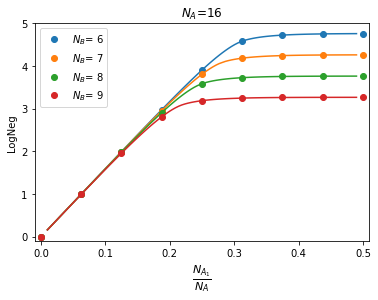

In [398]:
plt.figure()

for i_c in range(len(Nblist)):
    Nb=Nblist[i_c]
    plt.plot(np.arange(0,int(Na)/2+1)/Na, logneg_q_avg[:,i_c], 'o',color='C%d' % (i_c),label='$N_B$= %d' % Nb)
    plt.plot(R12_list,logneg[:,i_c],'-',color='C%d' % (i_c))
plt.title(r'$N_A$=%d' % (Na))
plt.ylim(-0.1,5.)
plt.xlim(-0.01,0.51)
plt.xlabel(r'$\frac{N_{A_1}}{N_A}$',fontsize=16)
plt.ylabel('LogNeg')
plt.legend()
plt.show()

In [461]:
1/(1-R12)/2

0.8333333333333334